In [2]:
%matplotlib inline
import scipy.stats
import os
import shutil
import re
import numpy as np
import pandas as pd
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
from Bio import SeqIO
from src import contig_stats
sns.set_style("whitegrid")

In [3]:
path = "/media/NGS/Sequence/Acinetobacter_baumannii/NCBI"

In [4]:
def run(args):
    file, filename = args
    fileroot = os.path.splitext(filename)[0]
    n25, n50, n75, m, c = contig_stats.stats(list(SeqIO.parse(fasta, "fasta")))
    return fileroot, n25, n50, n75, m, c

In [5]:
args = ((os.path.join(path, file), file) for file in os.listdir(path))
data = list(ProcessPoolExecutor(32).map(run, args, chunksize=5))

In [6]:
table = pd.DataFrame(data, columns=["id", "N25", "N50", "N75", "total_length", "counts"])
table.head()

,id,N25,N50,N75,total_length,counts
0,GCA_000372585.2,3937175,3937175,3937175,3937175,1
1,GCA_001028265.1,350122,246634,173203,3955466,34
2,GCA_000809485.3,75848,46128,28057,4184654,176
3,GCA_002212165.1,142502,66999,39307,4208417,244
4,GCA_002143685.1,197356,127969,74095,4045525,74


In [7]:
identify = pd.read_csv('/media/NGS/Sequence/Acinetobacter_baumannii/Identify.csv', index_col=0)
identify = identify[(identify['Species'] == 'Acinetobacter baumannii')]
table = pd.merge(table, identify, left_on='id', right_index=True)
table.head()

,id,N25,N50,N75,total_length,counts,Query_Coverage,Template_Coverage,Species
1,GCA_001028265.1,350122,246634,173203,3955466,34,99.16,98.74,Acinetobacter baumannii
2,GCA_000809485.3,75848,46128,28057,4184654,176,91.32,96.65,Acinetobacter baumannii
4,GCA_002143685.1,197356,127969,74095,4045525,74,94.62,98.23,Acinetobacter baumannii
6,GCA_000809325.3,98820,50669,33776,4174612,151,93.09,99.68,Acinetobacter baumannii
7,GCA_000515755.1,106420,58804,37513,4140181,231,94.65,95.63,Acinetobacter baumannii


# Combine metadata selection

In [8]:
metafile = "/media/NGS/Sequence/Acinetobacter_baumannii/METADATA.csv"
meta = pd.read_csv(metafile)
meta = meta[meta["GC%"] != "-"]
meta["GC%"] = meta['GC%'].astype(float)
meta = meta[meta['Size (Mb)'] != '-']
meta['Size (Mb)'] = meta['Size (Mb)'].astype(float)

In [9]:
curated = pd.merge(table, meta, left_index=True, left_on='id', right_on="Assembly")

In [10]:
def fence(df, subset):
    std = curated[subset].std()
    mean = curated[subset].mean()
    return (curated[subset]>(mean - 2*std))&(curated[subset]<(mean + 2*std))

In [12]:
curated['outlier'] = ~(fence(curated, 'Size (Mb)') & fence(curated, "GC%"))

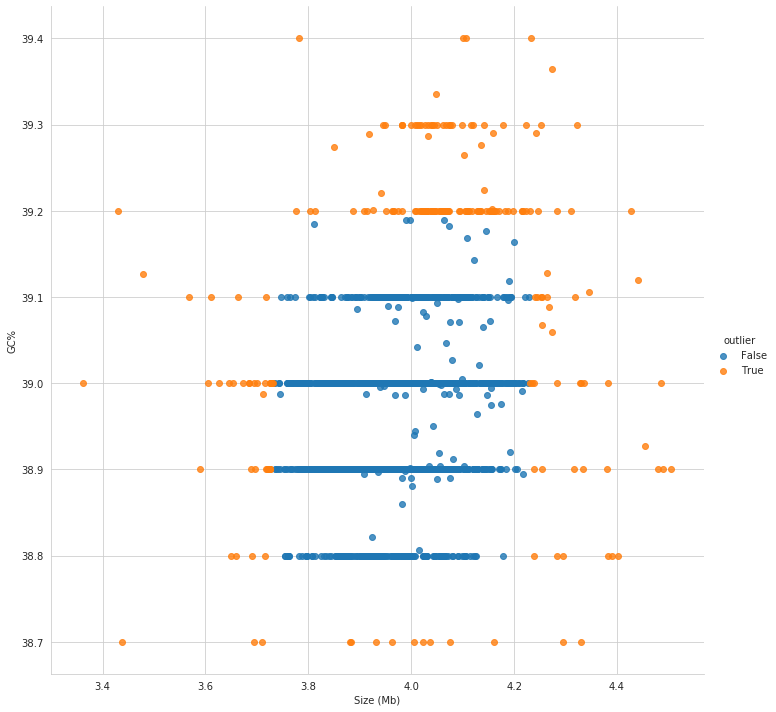

In [13]:
sns.lmplot(data=curated, x="Size (Mb)", y="GC%", fit_reg=False, height=10, hue='outlier')

In [14]:
curated = curated[~curated['outlier']]

In [15]:
curated.shape

(1738, 30)

# N25, N50, N75

Text(0, 0.5, 'number')

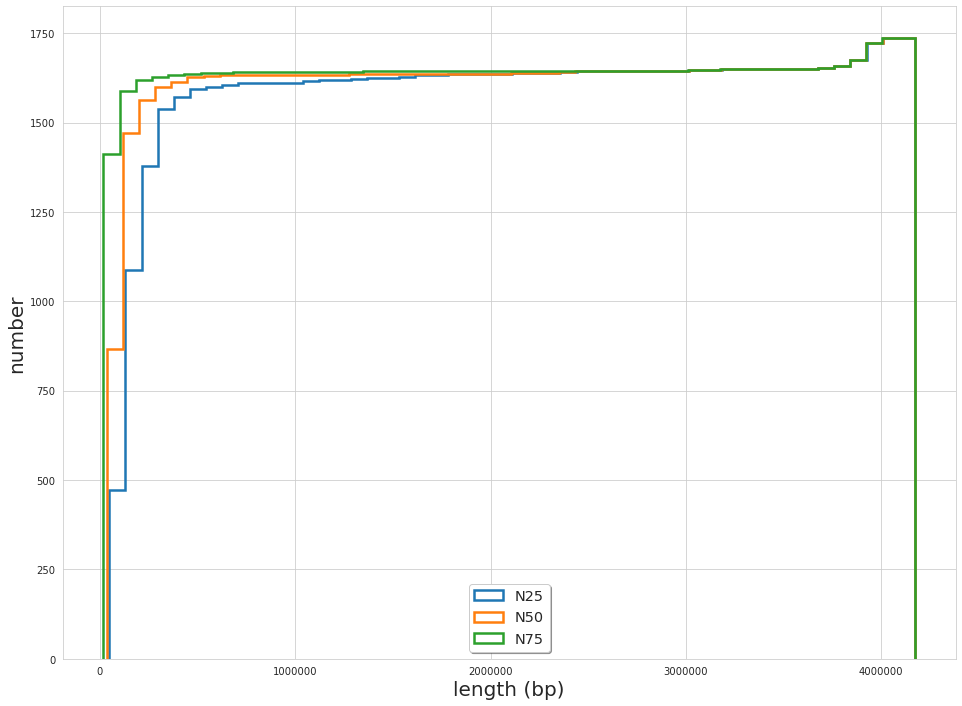

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(curated["N25"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N25")
ax.hist(curated["N50"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N50")
ax.hist(curated["N75"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N75")
ax.legend(loc='lower center', shadow=True, fontsize='x-large')
plt.xlabel("length (bp)", fontsize=20)
plt.ylabel("number", fontsize=20)

Text(0, 0.5, 'number')

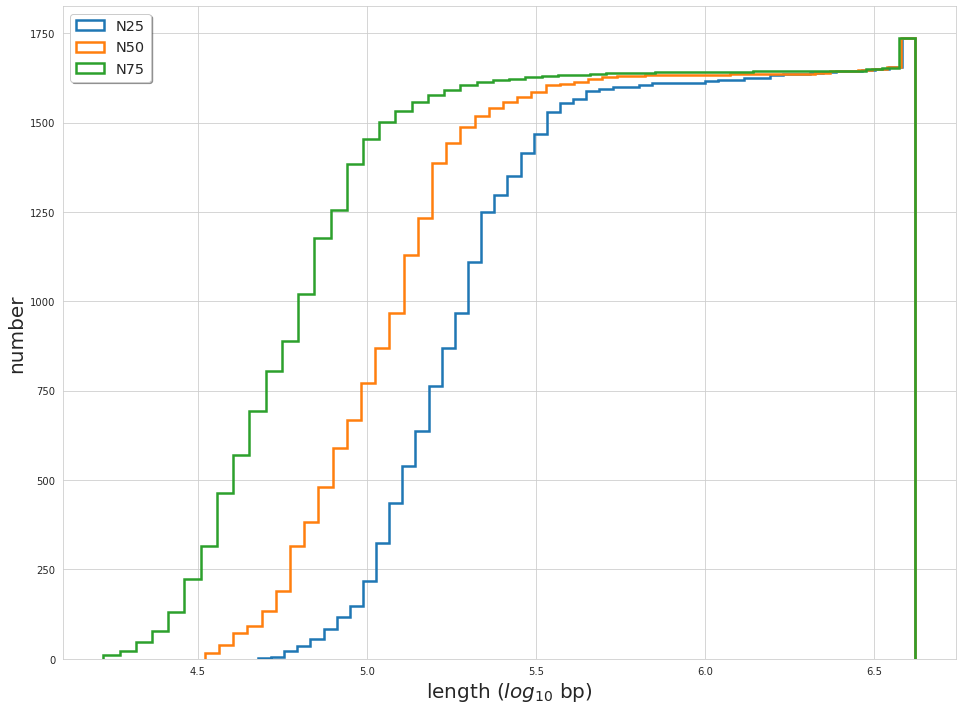

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(np.log10(curated["N25"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N25")
ax.hist(np.log10(curated["N50"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N50")
ax.hist(np.log10(curated["N75"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N75")
ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel("length ($log_{10}$ bp)", fontsize=20)
plt.ylabel("number", fontsize=20)

# comparison with serotypes

In [19]:
curated = curated[curated['N50'] >= 10 ** 5.3]
curated.shape

(265, 30)

Text(0.5, 1.0, 'Genome contig number distribution')

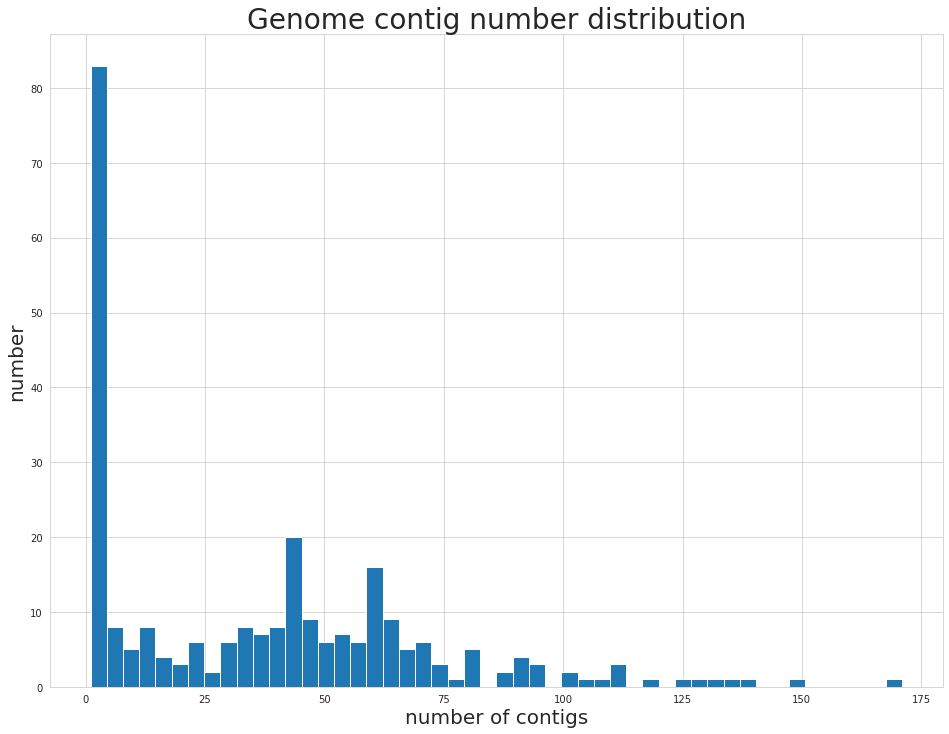

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(curated["counts"], bins=50)
plt.xlabel("number of contigs", fontsize=20)
plt.ylabel("number", fontsize=20)
plt.title("Genome contig number distribution", fontsize=28)

In [21]:
curated = curated[curated['counts']<100]

In [26]:
for i in curated['id']:
    shutil.copy(os.path.join(path, i + '.fna'), '/media/NGS/Sequence/Acinetobacter_baumannii/NCBI_clean')